### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import nltk
import sympy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    classification_report
)

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy
from nltk.sentiment import SentimentIntensityAnalyzer

### Import Data & Basic Inspection

In [35]:
df = pd.read_csv('playlist_revision_v05.txt', sep ='\t')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427276 entries, 0 to 427275
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   playlist_uri                      427276 non-null  object 
 1   owner                             427276 non-null  object 
 2   streams                           427276 non-null  int64  
 3   stream30s                         427276 non-null  int64  
 4   dau                               427276 non-null  int64  
 5   wau                               427276 non-null  int64  
 6   mau                               427276 non-null  int64  
 7   mau_previous_month                427276 non-null  int64  
 8   mau_both_months                   427276 non-null  int64  
 9   users                             427276 non-null  int64  
 10  skippers                          427276 non-null  int64  
 11  owner_country                     427276 non-null  o

mau_premium_ratio and mau_previous_month_premium_ratio seem to be redundant columns - providing no additional information. We can easily recover this information if required. Better to drop them.

In [14]:
df['mau_premium_ratio'].unique()

array([nan, 0.5])

In [18]:
df['mau_previous_month_premium_ratio'].unique()

array([ nan, 0.75])

In [30]:
df[df['mau_premium_ratio'] == 0.5][['mau','premium_mau']]

,mau,premium_mau
20472,28,NaN


No predictive element evident. Better to drop these columns.

In [37]:
df.drop(columns = ['mau_premium_ratio','mau_previous_month_premium_ratio'],inplace = True)

In [39]:
#statistical analysis (numerical columns)
df.describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,premium_mau_previous_month,premium_mau
count,4.272760e+05,4.272760e+05,427276.000000,427276.000000,4.272760e+05,4.272760e+05,427276.000000,4.272760e+05,427276.000000,427276.000000,427276.000000,427276.000000,427276.000000,4.272760e+05,427276.000000,427275.000000,4.272750e+05
mean,7.212229e+01,4.449239e+01,4.299673,21.192740,6.440589e+01,5.669391e+01,12.560825,1.454201e+02,2.734268,194.724101,2.979077,81.027820,85.269519,1.250349e+03,116.974953,37.095646,3.518560e+01
std,6.316762e+03,3.673820e+03,349.535428,1574.886035,4.619766e+03,3.741111e+03,1208.712012,9.042585e+03,199.744978,575.081233,39.460309,126.723869,131.827612,1.035363e+05,256.382438,2359.007039,2.474932e+03
min,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,1.000000e+00,1.000000,2.000000e+00,0.000000,34.000000,0.000000,16.000000,17.000000,3.200000e+01,7.000000,0.000000,1.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,2.000000e+00,1.000000,3.000000e+00,0.000000,80.000000,0.000000,44.000000,46.000000,8.400000e+01,32.000000,1.000000,2.000000e+00
75%,1.000000e+01,6.000000e+00,1.000000,2.000000,3.000000e+00,3.000000e+00,2.000000,7.000000e+00,0.000000,185.000000,0.000000,98.000000,103.000000,2.160000e+02,110.000000,3.000000,2.000000e+00
max,2.629715e+06,1.513237e+06,152929.000000,669966.000000,1.944150e+06,1.478684e+06,578391.000000,3.455406e+06,86162.000000,79984.000000,9117.000000,5226.000000,6397.000000,4.249733e+07,25904.000000,987995.000000,1.012068e+06


In [41]:
# check for null counts & datatype discrepancies
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427276 entries, 0 to 427275
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   playlist_uri                427276 non-null  object 
 1   owner                       427276 non-null  object 
 2   streams                     427276 non-null  int64  
 3   stream30s                   427276 non-null  int64  
 4   dau                         427276 non-null  int64  
 5   wau                         427276 non-null  int64  
 6   mau                         427276 non-null  int64  
 7   mau_previous_month          427276 non-null  int64  
 8   mau_both_months             427276 non-null  int64  
 9   users                       427276 non-null  int64  
 10  skippers                    427276 non-null  int64  
 11  owner_country               427276 non-null  object 
 12  n_tracks                    427276 non-null  int64  
 13  n_local_tracks

In [13]:
df.isnull().sum()

playlist_uri                  0
owner                         0
streams                       0
stream30s                     0
dau                           0
wau                           0
mau                           0
mau_previous_month            0
mau_both_months               0
users                         0
skippers                      0
owner_country                 0
n_tracks                      0
n_local_tracks                0
n_artists                     0
n_albums                      0
monthly_stream30s             0
monthly_owner_stream30s       0
tokens                        0
genre_1                       0
genre_2                       0
genre_3                       0
mood_1                        0
mood_2                        0
mood_3                        0
premium_mau_previous_month    1
premium_mau                   1
dtype: int64

Only one null value in two columns - we can **drop** these.

In [43]:
df.dropna(inplace=True)

### Observing Distributions

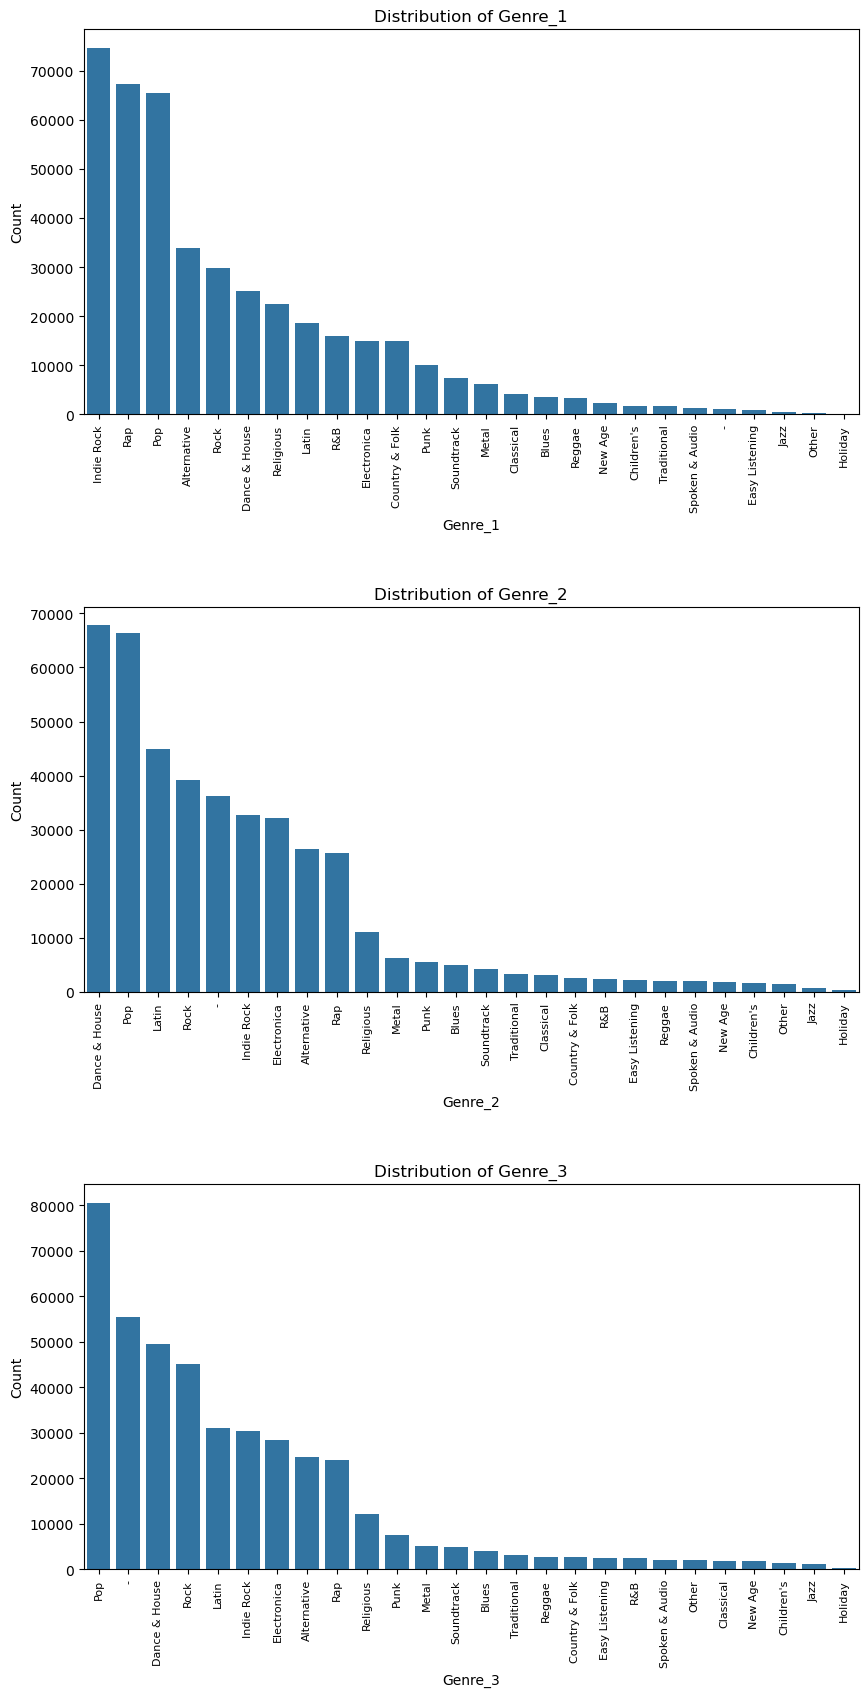

In [79]:
genre_cols = ['genre_1', 'genre_2', 'genre_3']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for i, col in enumerate(genre_cols):
    sorted_genres = df[col].value_counts().index
    # Create the countplot with sorted order
    sns.countplot(data=df, x=col, ax=axes[i], order=sorted_genres)
    axes[i].set_title(f'Distribution of {col.title()}')
    axes[i].set_xlabel(col.title())
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, fontsize=8)

plt.subplots_adjust(hspace=0.5)

plt.show()

**Comments:**

Certain genres (Pop, Rock, Dance) tend to appear frequently in all three genres. However, other columns have a fair representation too (especially given the scale of 10K. We can benefit by knowing if a specifc group of genre's (co-occurence), when belonging to a playlist, tend to help with streams/users. **(Topic Modeling)** may be employed. Holiday and Jazz seem to be rare entries. No typo errors spotted. No special treatment seems necessary.


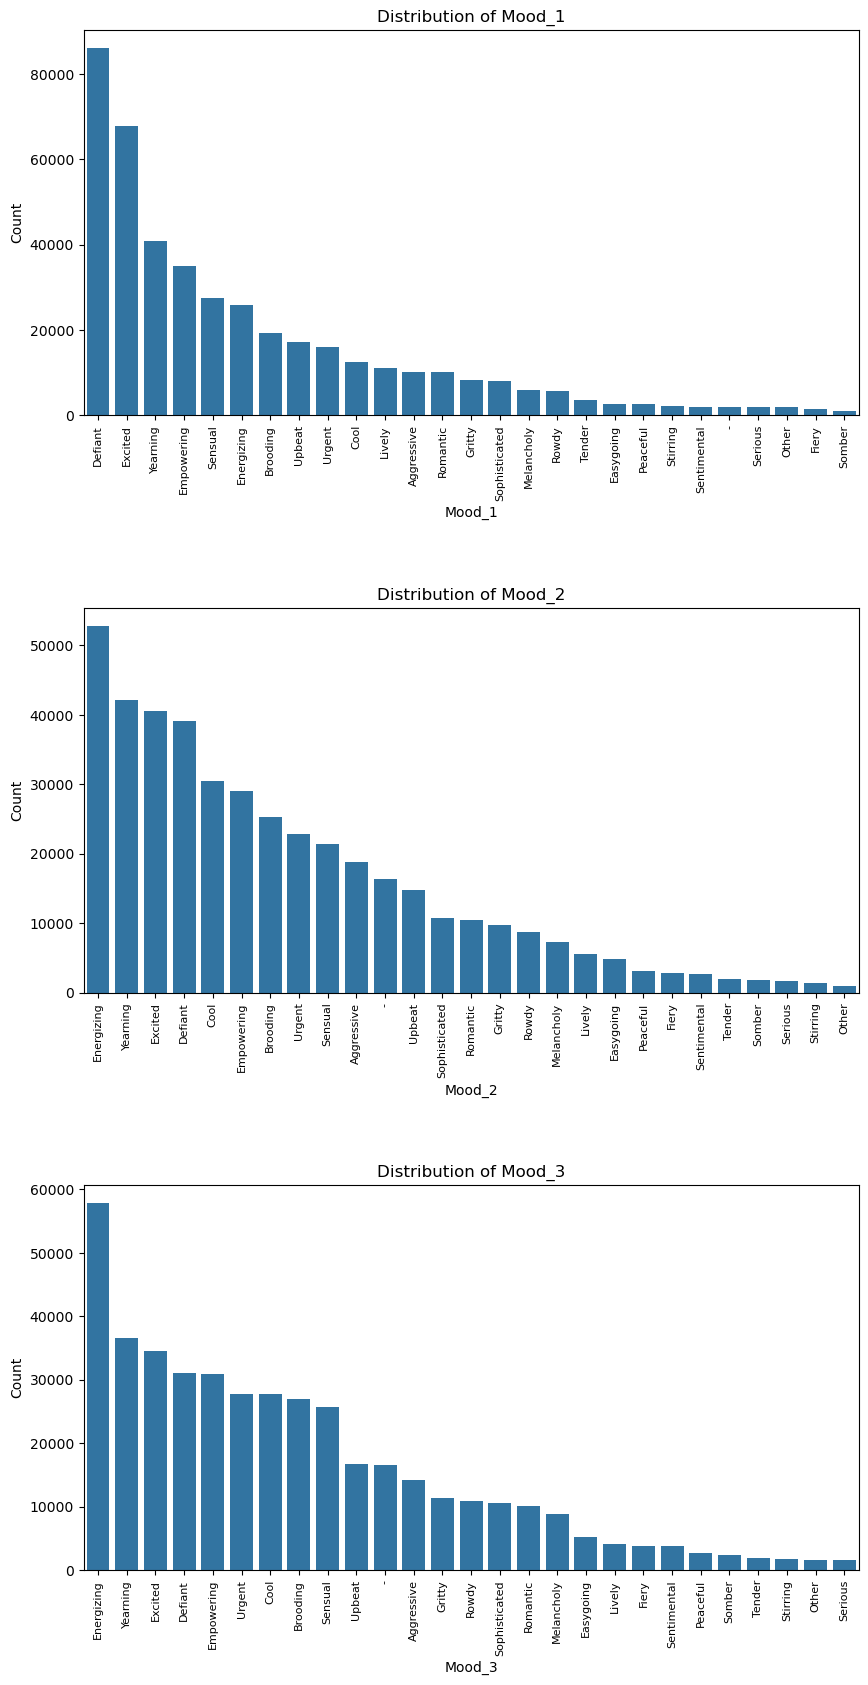

In [88]:
mood_cols = ['mood_1', 'mood_2', 'mood_3']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for i, col in enumerate(mood_cols):
    sorted_genres = df[col].value_counts().index
    # Create the countplot with sorted order
    sns.countplot(data=df, x=col, ax=axes[i], order=sorted_genres)
    axes[i].set_title(f'Distribution of {col.title()}')
    axes[i].set_xlabel(col.title())
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, fontsize=8)

plt.subplots_adjust(hspace=0.5)

plt.show()

**Comments**:
Similar trend like Genre. Since moods contain "sentiments", some sort of **sentiment scoring** would be better than topic modeling.

In [95]:
df["spotify_owned"] = df["owner"].apply(lambda x: 1 if x.lower() == "spotify" else 0)

<Axes: xlabel='spotify_owned', ylabel='count'>

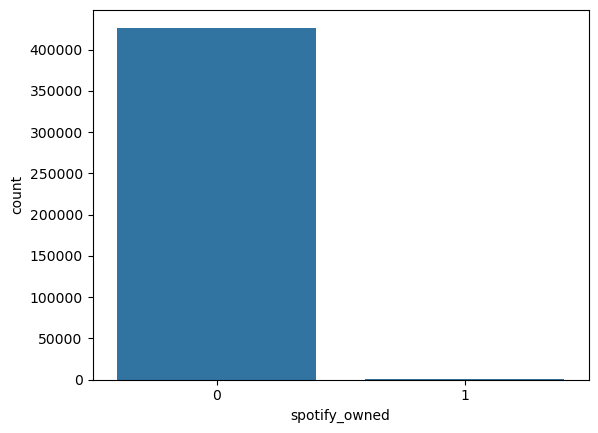

In [97]:
sns.countplot(data=df, x='spotify_owned')

**Comments:** Most values seemed to be owned by individual users/artists. Spotify itself represents a miniscule proportion of the entire dataset.

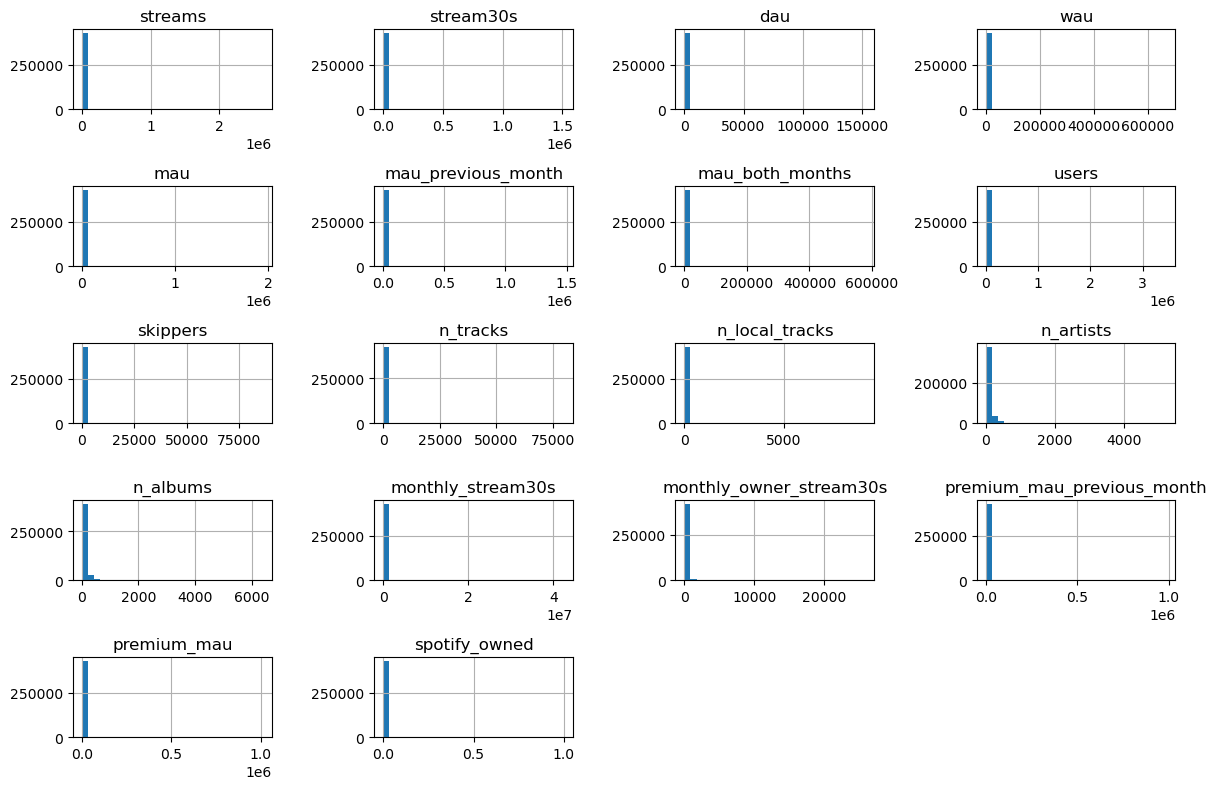

In [100]:
#Distribution - Numerical Columns

df.select_dtypes(include=['number']).hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

**Comments**: High concentration of data within a specific range. Barely see any values - need to identify and *filter out* outliers. 

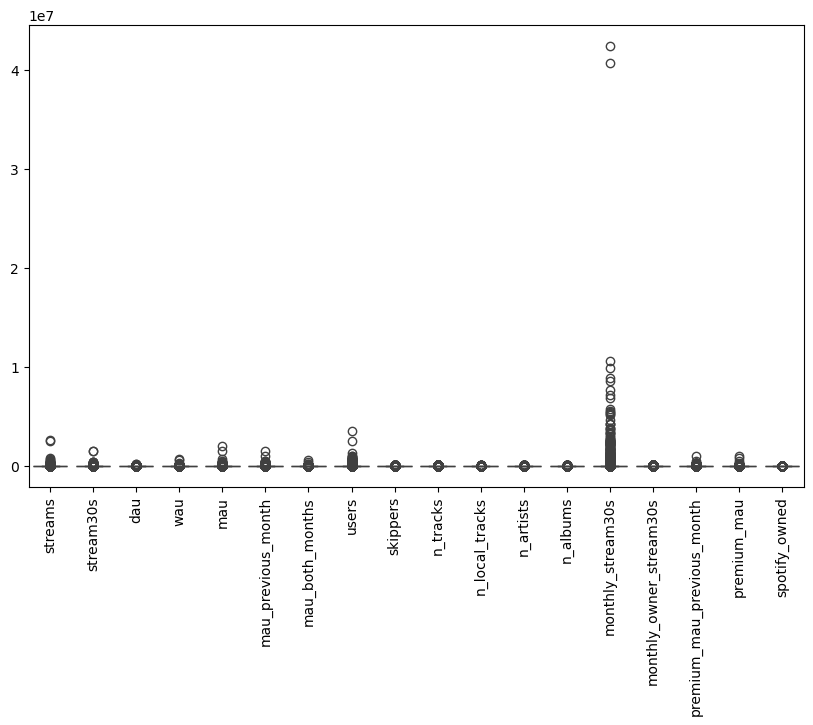

In [103]:
#Box Plot - Obsering Range similarities and outliers (What do we filter out?)
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Outliers seem to be present in almost every numerical column. We will address two of these (monthly_stream30s & n_tracks) right away. For others, instead of employing usual techniques like IQR/Z-Score/Isokation Foresets, we will handle these outliers **individually**, depending on our definition of success. (Turns out, these outliers are rather important, and do not hamper the quality of our ensemble model).

In [106]:
df = df[(df['monthly_stream30s'] <= 500)&(df['n_tracks'] <= 500)]

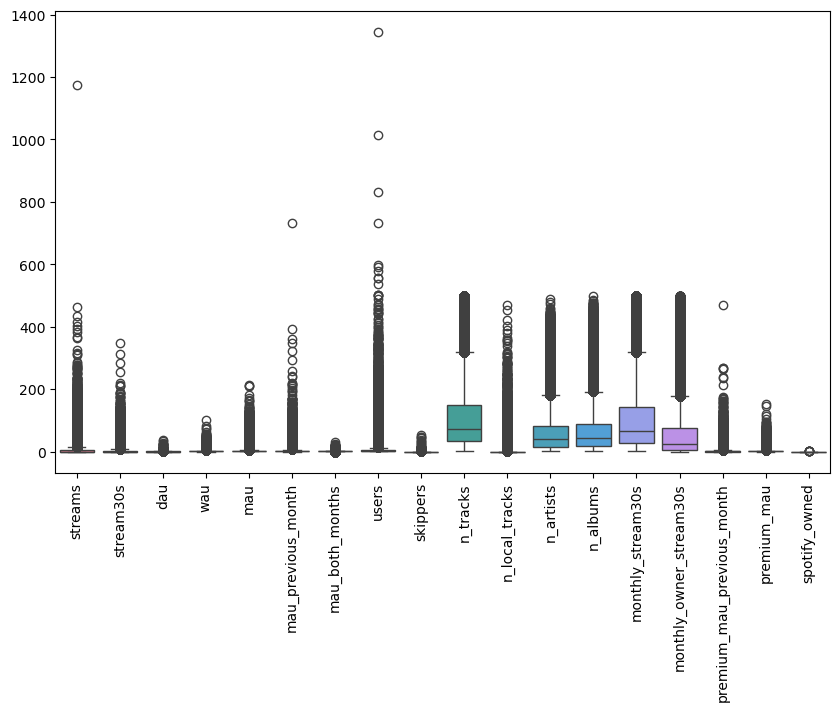

In [108]:
#Box Plot - Obsering Range similarities and outliers (What do we filter out?)
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

**Comments**

Simply removing two outliers helps restore some structure to the data. We **need not** handle all of them at once - as we will filter them before our modeling stage as per requirement.

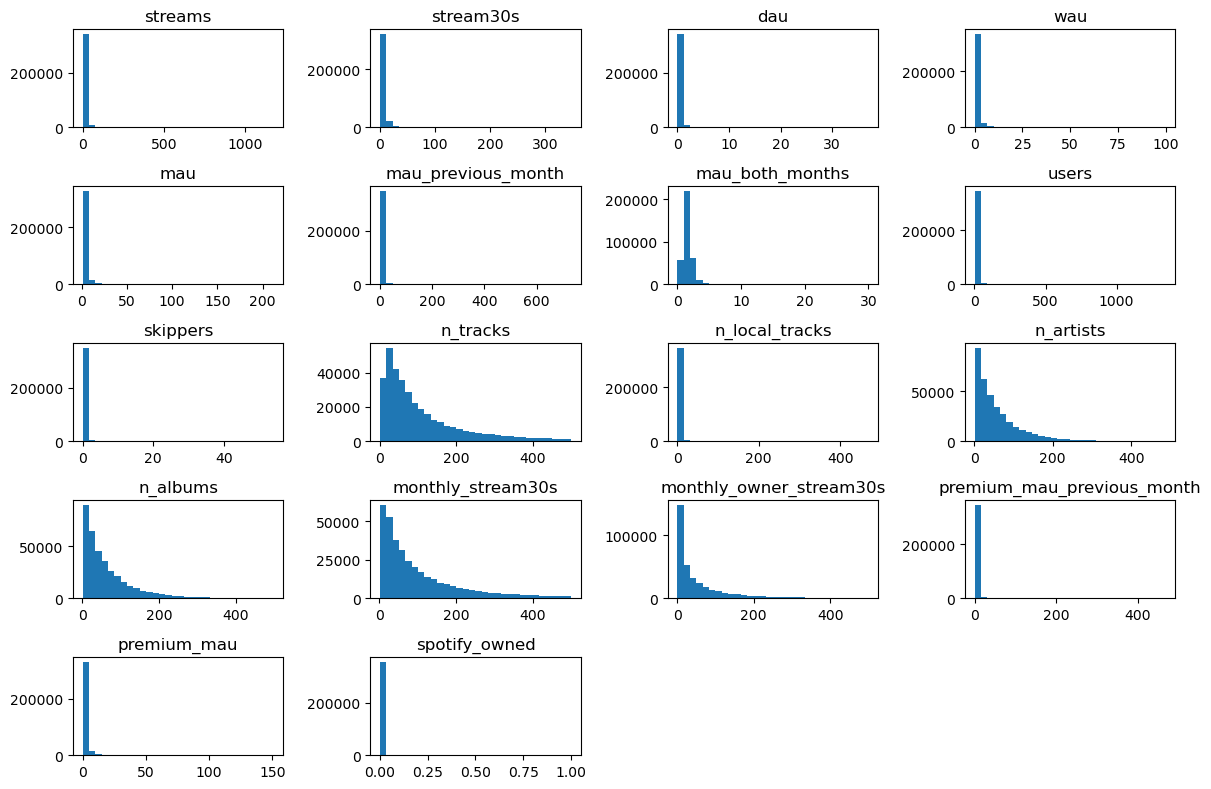

In [125]:
#Lets try to observe this plot again
df.select_dtypes(include=['number']).hist(bins=30, grid= False, figsize=(12, 8))
plt.tight_layout()
plt.show()

**Comments**

We can now observe some distributions in the numerical columns. Clearly, most columns have a heavy positive bias. This is well within expectation, as most values of tracks, artistis, streams are concentrated at lower tails. 

Potential adjustments could be made to the data - like performing log transformations/robust scaling etc. However - I decided not to scale or standardize this data, since I wanted to retain the shape of the original data. Interpretability is another reason why keeping these values in their original form would help - we can then bin the data as per real-values and check if a specific range helps playlist gain traction.

In [128]:
#checking unique values in the df
df.nunique()

playlist_uri                  345560
owner                         272438
streams                          250
stream30s                        166
dau                               23
wau                               59
mau                              141
mau_previous_month               172
mau_both_months                   25
users                            353
skippers                          26
owner_country                      1
n_tracks                         500
n_local_tracks                   254
n_artists                        448
n_albums                         471
monthly_stream30s                499
monthly_owner_stream30s          501
tokens                        168494
genre_1                           26
genre_2                           26
genre_3                           26
mood_1                            27
mood_2                            27
mood_3                            27
premium_mau_previous_month       140
premium_mau                       90
s

**Owner Country** column is univariate. We can drop it.

**Multicollinearity** - Are any of the columns highly correlated?

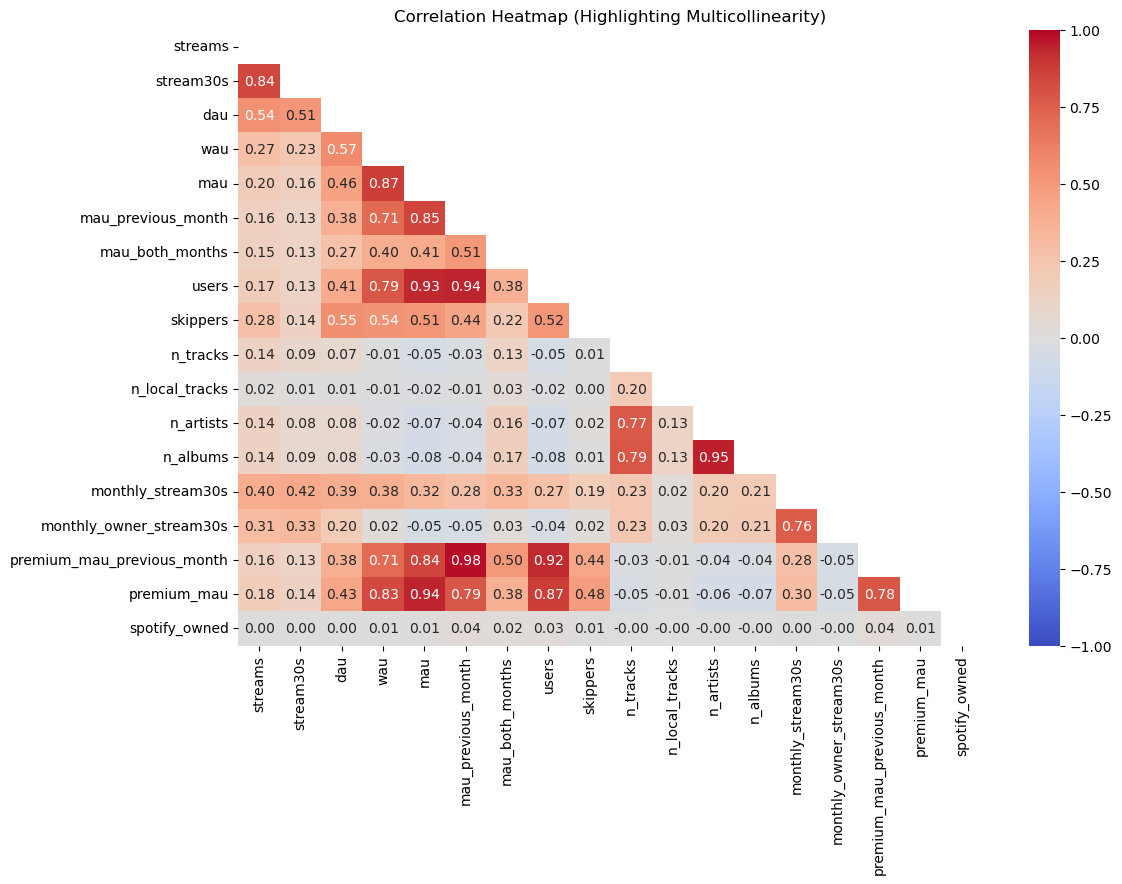

In [152]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)

plt.title("Correlation Heatmap (Highlighting Multicollinearity)")
plt.show()

In [154]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.8

high_corr_pairs = [(col, idx, upper_tri.loc[idx, col]) 
                   for col in upper_tri.columns 
                   for idx in upper_tri.index 
                   if abs(upper_tri.loc[idx, col]) > threshold]

if high_corr_pairs:
    print("Columns with high multicollinearity (correlation > 0.8):")
    for col1, col2, corr in high_corr_pairs:
        print(f"{col1} and {col2}: {corr:.2f}")
else:
    print("No high multicollinearity detected.")

Columns with high multicollinearity (correlation > 0.8):
stream30s and streams: 0.84
mau and wau: 0.87
mau_previous_month and mau: 0.85
users and mau: 0.93
users and mau_previous_month: 0.94
n_albums and n_artists: 0.95
premium_mau_previous_month and mau: 0.84
premium_mau_previous_month and mau_previous_month: 0.98
premium_mau_previous_month and users: 0.92
premium_mau and wau: 0.83
premium_mau and mau: 0.94
premium_mau and users: 0.87


**Comments**

Certain pairs of columns exhibit high multicollinearity—meaning that if we know how one feature changes, we can predict with high certainty how another will change.

**Why this may be a problem?**

In a linear model, multicollinearity can lead to unstable coefficients. If two features (A and B) move in the same direction, the model struggles to determine *which* one actually drives changes in the output.

**Why this isn't a problem for us?**

a) Most of these correlated pairs *(except n_albums and n_artists)* contribute to the target column, not the feature set. Since they are not predictors, they won’t affect the model.

b) As we will see in the Modeling Section, our data follows non-linear patterns. Since we plan to use a non-linear model, strong collinearity will not significantly impact performance.